In [ ]:
import pandas as pd
import sys
sys.path.append("../../../") 
entropy = pd.read_pickle('../entropy.pkl')

(113139, 7)

(43, 3)


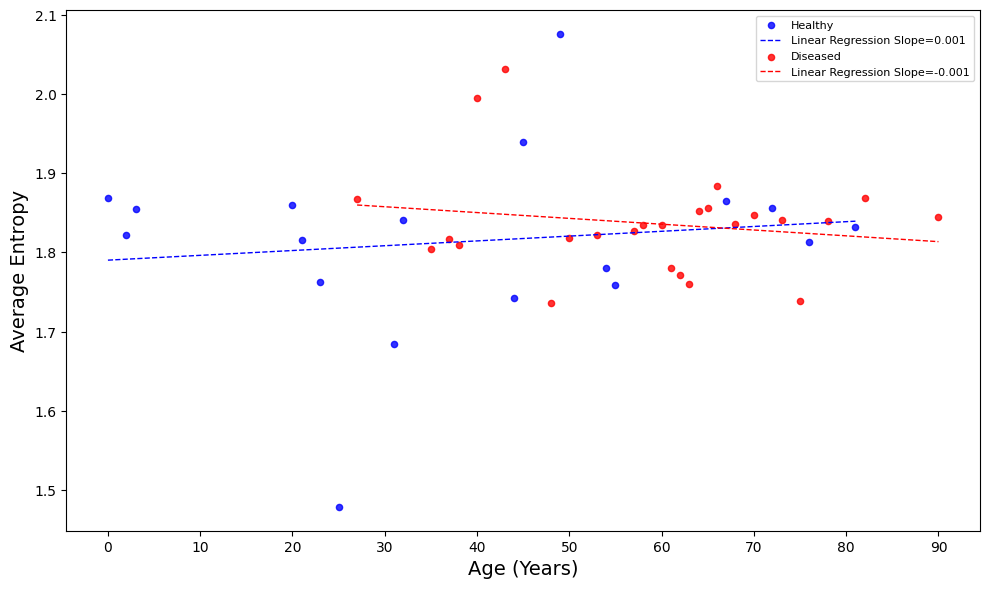

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
from perturbgene.data_utils.tokenization import normalise_str
age_relabel = pd.read_csv('../age_relabeling.csv', index_col=0)
age_map = {k:v for k,v in zip(age_relabel['label'], age_relabel['age'])}

from scipy.stats import ttest_ind, zscore, pearsonr
from sklearn.metrics import r2_score
def cal_z_score(ground_truth, predictions):

    r, p = pearsonr(ground_truth, predictions)
    age_gap = predictions - ground_truth
    z_scored_age_gap = zscore(age_gap)
    return {
        "ground_truth": ground_truth,
        "prediction": predictions,
        "z_score":z_scored_age_gap,
        "r_value":r,
        "p_value":p,
        "rsquared": r2_score(ground_truth, predictions)}

from scipy.stats import linregress

def plot_entropy_by_age(dataframe, x_column, y_column, title=""):
    plt.figure(figsize=(10, 6))
    healthy_data = dataframe[dataframe["disease"] == 'normal']
    diseased_data = dataframe[dataframe["disease"] != 'normal']
    
    predicted, ground_truth = healthy_data[x_column], healthy_data[y_column]
    slope, intercept, _, _, _= linregress(x=predicted, y=ground_truth)
    sns.regplot(data=healthy_data, x=x_column, y=y_column, color='blue', scatter_kws={'s': 20}, line_kws={'lw': 1, 'linestyle': '--', 'label': f'Linear Regression Slope={slope:.3f}'}, label='Healthy', ci=None)
    if diseased_data.shape[0]:
        predicted, ground_truth = diseased_data[x_column], diseased_data[y_column]
        slope, intercept, _, _, _= linregress(x=predicted, y=ground_truth)
        sns.regplot(data=diseased_data, x=x_column, y=y_column, color='red', scatter_kws={'s': 20}, line_kws={'lw': 1, 'linestyle': '--', 'label': f'Linear Regression Slope={slope:.3f}'}, label='Diseased', ci=None)
    correlation = cal_z_score(ground_truth, predicted)
    r = correlation["r_value"]
    p = correlation["p_value"]
    rsq = correlation["rsquared"]
    #plt.text(0.05, 0.95, f'Slope = {slope:.4f}\n$R^2$ = {max(rsq, 0):.2f}\n$\\rho$ = {r:.2f}\np = {p:.2e}', 
    #transform=plt.gca().transAxes, fontsize=12, verticalalignment='top',
    #bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="black"))
    import numpy as np
    plt.xticks(np.arange(0, 100, 10), labels=np.arange(0, 100, 10))
    plt.xlabel('Age (Years)', fontsize=14)
    plt.ylabel('Average Entropy', fontsize=14)
    #plt.title(f'Average Entropy for Healthy {title.capitalize()} tissue', fontsize=14)
    plt.legend(fontsize=8)
    plt.tight_layout()
    plt.savefig(f'{tissue}-regression-plot.svg', bbox_inches='tight', dpi=300)
    plt.show()

for tissue in ['lung']:
    entropy['age'] = entropy['development_stage'].apply(lambda x: age_map[normalise_str(x)])
    df_group = entropy[(entropy['tissue_general']==tissue)].groupby("age").apply(lambda g: pd.Series({"entropy": g["tissue_entropy"].mean(), 'disease': g['disease'][0]})).reset_index()
    #display(df_group.sample(3))
    print(df_group.shape)
    plot_entropy_by_age(df_group, "age", "entropy", tissue)

33


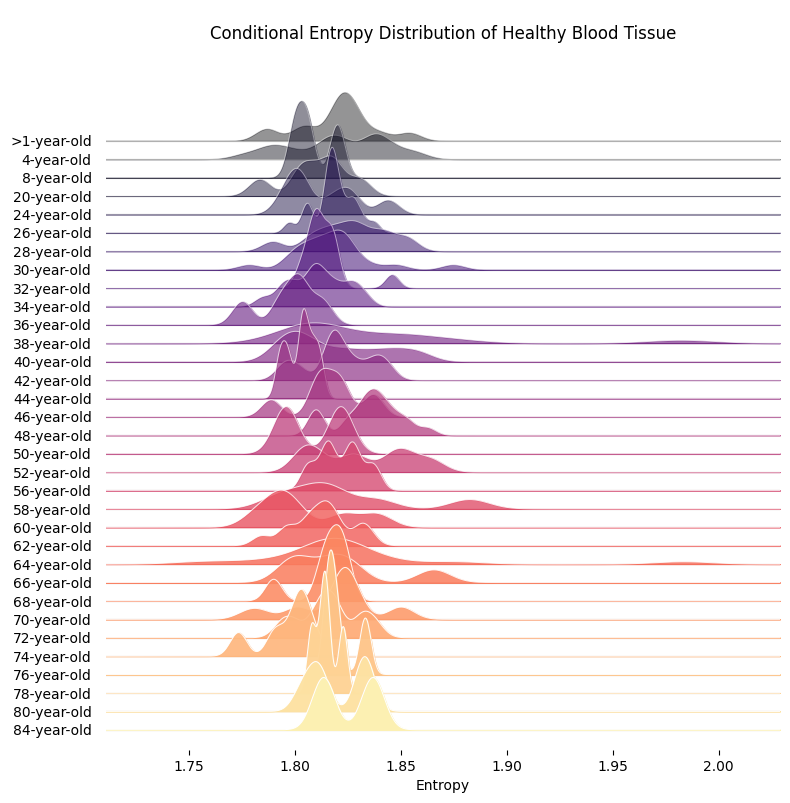

In [26]:
import joypy
import numpy as np
ceil_ages = lambda ages, ceil=5: np.clip((np.ceil(ages) / ceil).astype(int) * ceil, 0, 100)
n_samples = 100
for tissue in ['blood']:
    #df_group = df[(df['tissue_general']==tissue) & (df['disease']=="normal")].groupby("development_stage").apply(lambda g: pd.Series({"entropy": g["tissue_entropy"].tolist(),}))
    #display(df)
    df_m = entropy[(entropy['tissue_general'] == tissue) & (entropy['disease'] == 'normal')].copy()
    
    #df_m = df_m.groupby("age").apply(lambda group: group.sample(n=n_samples, replace=True)).reset_index(drop=True)
    df_m['age'] = df_m['age'].apply(lambda a: int(ceil_ages(a, ceil=2)))
    age_dict = dict(sorted(df_m.groupby('age')['tissue_entropy'].apply(np.array).items(), key=lambda x: x))
    min_count = 50
    age_dict = {age: values for age, values in age_dict.items() if len(values) >= min_count}
    #age_dict = {age: values for age, values in age_dict.items() if np.std(values) >= min_std}
    df_filtered = pd.DataFrame([(age, value) for age, values in age_dict.items() for value in values], columns=['age', 'values'])
    print(len([f'{x}-year-old' for x in list(age_dict)]))
    fig, axes = joypy.joyplot(
      df_filtered,
      by="age",
      labels=[f'{x}-year-old'  if x != 0 else f'>1-year-old'  for x in list(age_dict)],
      column="values",
      overlap=2,               # Increase overlap for smoother visual effect
      linecolor='w',           # White outline for better contrast
      linewidth=0.75,          # Slightly thicker line width
      figsize=(8, 8),         # Increase figure size for better visibility
      colormap=sns.color_palette('magma', as_cmap=True),     # Use a vibrant color map (viridis)
      grid="y",
      #alpha=0.9,            # Add horizontal grid lines for a cleaner look
      fade=True                # Gradual fading effect to add depth to the plot
    )
    plt.title(f"Conditional Entropy Distribution of Healthy {tissue.capitalize()} Tissue", y=0.95)
    plt.xlabel("Entropy")
    plt.savefig('blood-tissue.svg', bbox_inches='tight', dpi=300)
    plt.show()